Single-step: Computes 1 day ahead predictions, based on previous data from that day.
- Predicts close price 1 day into the future.

**PROBLEM**: Distribution shift
- Model works great for NTDOY (variance in both training and testing sections)
- Model works okay for MSFT (Greater variance in testing section compared to training)

**SOLUTION**:
- Probably predicting returns instead of prices.
- Adjusting data limits.

- This version of the model works very well if the max and min of the data available is within the training (first 80%) set of the data.

The input sequence is a sliding window of real test data freatures. The predictions are just for the next day. Therefore:
- It is not recursively making long term predictions based on previous findings.

- Currently what I'm doing: Looking at the data, cutting off from right/left based on the fluctuations to eliminate distribution shift.
- This is a more temporary solution but I found it appropriate for my purpose given my goal and limited time.

In [1]:
# Import data
import yfinance as yf
stock_df = yf.download("MSFT", start="2010-01-01", end="2025-06-30")
stock_df.tail()

/tmp/ipython-input-1-2873001021.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download("MSFT", start="2010-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-06-23,486.000000,487.750000,472.510010,478.209991,24864000
2025-06-24,490.109985,491.850006,486.799988,488.950012,22305600
2025-06-25,492.269989,494.559998,489.390015,492.040009,17495100
2025-06-26,497.450012,498.040009,492.809998,492.980011,21578900
2025-06-27,495.940002,499.299988,493.029999,497.549988,34539200


In [2]:
# Check for any null data
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3895 entries, 2010-01-04 to 2025-06-27
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MSFT)   3895 non-null   float64
 1   (High, MSFT)    3895 non-null   float64
 2   (Low, MSFT)     3895 non-null   float64
 3   (Open, MSFT)    3895 non-null   float64
 4   (Volume, MSFT)  3895 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 182.6 KB


In [3]:
# Check statistics in the data
stock_df.describe()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
count,3895.000000,3895.000000,3895.000000,3895.000000,3.895000e+03
mean,138.363992,139.629147,136.952132,138.308503,3.575882e+07
std,132.895663,134.058762,131.575460,132.832293,2.070287e+07
min,17.415640,17.650267,17.203712,17.476186,7.164500e+06
25%,30.002934,30.211085,29.669889,29.961300,2.235615e+07
50%,68.664963,69.096618,68.242541,68.811909,2.981890e+07
75%,239.817406,242.295144,237.313002,239.657225,4.382790e+07
max,497.450012,499.299988,493.029999,497.549988,3.193179e+08


In [4]:
#Create the target column, as the price of close on the next day
stock_df["Target_Close"] = stock_df["Close"].shift(-1)
stock_df = stock_df.dropna()
stock_df

Price,Close,High,Low,Open,Volume,Target_Close
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,
Date,,,,,,
2010-01-04,23.211432,23.323926,22.941443,22.963943,38409100,23.218946
2010-01-05,23.218946,23.323943,22.978958,23.136451,49749600,23.076445
2010-01-06,23.076445,23.308934,22.888953,23.158940,58182400,22.836462
2010-01-07,22.836462,23.023953,22.641471,22.971455,50559700,22.993944
2010-01-08,22.993944,23.158936,22.678959,22.708958,51197400,22.701460
...,...,...,...,...,...,...
2025-06-20,477.399994,483.459991,476.869995,482.230011,37576200,486.000000
2025-06-23,486.000000,487.750000,472.510010,478.209991,24864000,490.109985


In [5]:
# Remove the Ticker level from the headers (To make it clearer)
stock_df.columns = stock_df.columns.get_level_values(0)


In [6]:
# Remove NaN values (The last row of Target_Close)
stock_df = stock_df.dropna(subset=["Target_Close"])

In [7]:
# Add statistical indicators to the data

stock_df["SMA_10"]  = stock_df["Close"].rolling(10).mean()
stock_df["STD_10"]  = stock_df["Close"].rolling(10).std()

# MACD
# 12-day and 26-day EMAs
ema_fast = stock_df['Close'].ewm(span=12, adjust=False).mean()
ema_slow = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['MACD']        = ema_fast - ema_slow

# 9-day EMA of the MACD (signal line)
stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

# ——— RSI ———
delta = stock_df['Close'].diff()
gain  = delta.clip(lower=0)
loss  = -delta.clip(upper=0)

# average gains/losses over 14 periods
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs       = avg_gain / avg_loss
stock_df['RSI'] = 100 - (100 / (1 + rs))

# drop the NaNs created by the indicators
stock_df.dropna(inplace=True)


stock_df = stock_df.dropna()
stock_df

Price,Close,High,Low,Open,Volume,Target_Close,SMA_10,STD_10,MACD,MACD_Signal,RSI
Date,,,,,,,,,,,
2010-01-25,21.988989,22.243977,21.823997,21.928992,63373000,22.123985,22.685713,0.521015,-0.225758,-0.113657,33.861422
2010-01-26,22.123985,22.386474,21.816500,21.898996,66639900,22.251484,22.627966,0.550258,-0.250780,-0.141082,36.015150
2010-01-27,22.251484,22.363978,21.764006,22.011495,63949500,21.869003,22.597968,0.562923,-0.257356,-0.164337,39.423062
2010-01-28,21.869003,22.401480,21.666512,22.378980,117513700,21.134035,22.508722,0.603412,-0.290086,-0.189487,38.033334
2010-01-29,21.134035,22.438975,20.744053,22.423976,193888500,21.306530,22.300231,0.685372,-0.371054,-0.225800,29.870212
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-20,477.399994,483.459991,476.869995,482.230011,37576200,486.000000,475.532001,3.658546,11.626716,12.669133,73.406609
2025-06-23,486.000000,487.750000,472.510010,478.209991,24864000,490.109985,477.094000,4.460968,11.773637,12.490034,77.690721
2025-06-24,490.109985,491.850006,486.799988,488.950012,22305600,492.269989,478.829999,5.768793,12.082436,12.408514,79.182798


In [8]:
# Check for correlation of features with target
import pandas as pd
corr_matrix = stock_df.corr()
print(corr_matrix["Target_Close"].sort_values(ascending=False))

Price
Target_Close    1.000000
Close           0.999726
High            0.999673
Low             0.999667
Open            0.999585
SMA_10          0.999122
STD_10          0.804697
MACD_Signal     0.272915
MACD            0.264813
RSI             0.034920
Volume         -0.386932
Name: Target_Close, dtype: float64


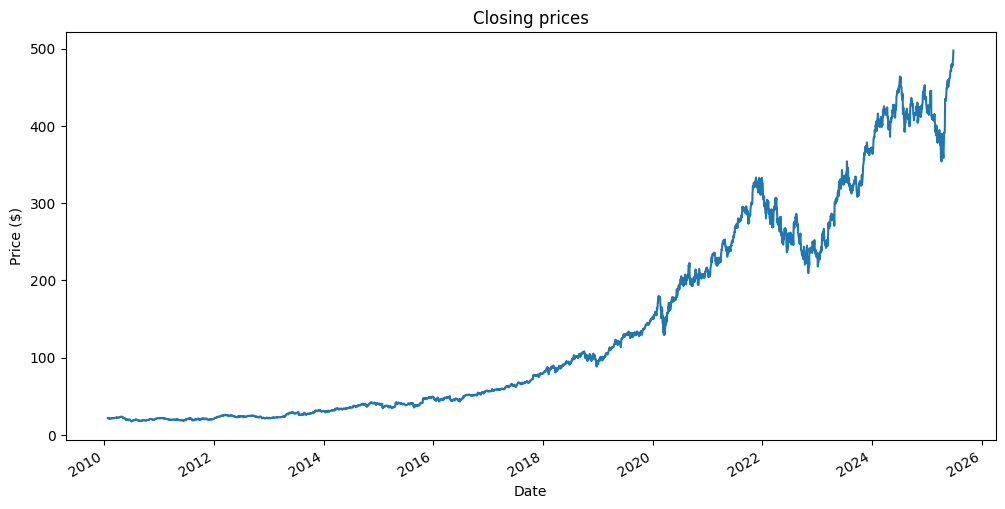

In [9]:
# Plot the true values of the closing times (for comparison later)
import matplotlib.pyplot as plt
stock_df["Close"].plot(figsize=(12,6), title="Closing prices")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

In [10]:
# Divide independent (target) and dependent variables
X = stock_df.drop("Target_Close", axis=1)
y = stock_df["Target_Close"]


In [11]:
# Split the data first, then fit a scaler on them.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=False)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Create the scalers
X_scaler = MinMaxScaler()
y_scaler = StandardScaler()

# Fit (train sets only) and transform (both sets) the data with the scalers
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1,1))


In [12]:
# Print train/test data edges for visual analysis.
print("TRAIN from", X_train.index.min(), "to", X_train.index.max())
print(" TEST from", X_test.index.min(),  "to", X_test.index.max())

X_train, X_test = X_train_scaled, X_test_scaled
y_train, y_test = y_train_scaled, y_test_scaled

TRAIN from 2010-01-25 00:00:00 to 2022-05-20 00:00:00
 TEST from 2022-05-23 00:00:00 to 2025-06-26 00:00:00


In [13]:
# Convert the NumPy arrays into torch tensors so that PyTorch can perform operations on them

import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Tensor shape is: [num_elements, num_featuers] But it has to be --> [batch_size, sequence_length, num_features].   (num_elements is essentially batch_size).
#sequence_length = Lookback days, num_features = Features per day

Data will look like this:
Assuming seq_len = 10:
- Input sequence: Rows 0-9
- Target: Value of close on day 10
- Next sequence: Rows 1-11
- Target: Value of close on day 11
- Next sequence: Rows 2-12
- Target: Value of close on day 12

In [14]:
from torch.utils.data import Dataset

class StockDataset(Dataset):  # Slices full-time series into overlapping windows (sequences)

  """
    Custom Dataset for time-series sequences.

    For each starting index:
      - X_seq = features from days t to t+seq_len-1
      - y_target = close price of day t+seq_len

    This setup means:
      - We predict the next day's close price (t+1) after our input window.
      - This is a single-step forecast.
  """

  def __init__(self, X, y, seq_len):
      self.X = X
      self.y = y
      self.seq_len = seq_len

  def __len__(self):  # Returns the number of training samples you can make
      return len(self.X) - self.seq_len

  def __getitem__(self, index): # Creates one sample (window)
      X_seq = self.X[index : index + self.seq_len]
      y_target = self.y[index + self.seq_len - 1] # Since target is shifted initially (Target_close = Close + 1), we must -1 here.
      return X_seq, y_target

# This dataset converts the dataset from [num_elements, num_features] --> many overlapping windows of shape: [seq_length, num_features].

In [15]:
from torch.utils.data import DataLoader

# train_loader exists so that the model can efficiently and randomly sample mini-batches

train_dataset = StockDataset(X_train_tensor, y_train_tensor, seq_len=28)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # The overlapping windows are batched with batch size 16, making the shape: [16, seq_len, num_features]

In [16]:
for X_batch, y_batch in train_loader:
  print(X_batch.shape, y_batch.shape)
  break

torch.Size([16, 28, 10]) torch.Size([16, 1])


In [17]:
import torch.nn as nn

# Create the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(          # Creates LSTM Cells
            input_size=input_size,        # Number of features
            hidden_size=hidden_size,      # Size of the LSTM's memory
            num_layers=num_layers,        # How many LSTM layers to stack
            batch_first=True,             # Makes input shape always [batch_size, seq_len, num_features]
            dropout=dropout               # Randomly zeros connections between layers for regularization
        )

        self.fc = nn.Linear(hidden_size, 1)

        # At each timestep hidden processes are completed within the LSTM cell (Forget, Input, Output gate operations)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)      # out: shape [batch_size, seq_len, hidden_size]. Contains the hidden state for every timestamp in the sequence (Accumulated)
                                          # hn: Hidden state after the last timestamp. Shape [num_layers, batch_size, hidden_size]
                                          # cn: Cell state after the last timestamp. Shape [num_layers, batch_size, hidden_size]

        out = out[:, -1, :] # Take the output of the final timestamp

        y_prediction = self.fc(out)  # Pass it into a final layer to produce the forecast for the next value
        return y_prediction  # Retrieve the forecast value.


In [18]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        #self.fc = nn.Linear(hidden_size, 1)

        self.norm = nn.LayerNorm(input_size)

    def forward(self, x):
        out, hn = self.gru(x)
        out = out[:, -1, :]
        y_prediction = self.fc(out)
        return y_prediction

Now, this input is feasible for LSTM to work.

In [19]:
X_train_tensor

tensor([[0.0145, 0.0143, 0.0147,  ..., 0.4631, 0.4512, 0.2223],
        [0.0149, 0.0147, 0.0146,  ..., 0.4618, 0.4496, 0.2480],
        [0.0153, 0.0146, 0.0145,  ..., 0.4615, 0.4481, 0.2886],
        ...,
        [0.7296, 0.7439, 0.7278,  ..., 0.0627, 0.0431, 0.2021],
        [0.7267, 0.7259, 0.7251,  ..., 0.0420, 0.0239, 0.2514],
        [0.7250, 0.7285, 0.7082,  ..., 0.0284, 0.0053, 0.1828]])

In [20]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([3104, 10]),
 torch.Size([3104, 1]),
 torch.Size([776, 10]),
 torch.Size([776, 1]))

In [21]:
# After optuna:
torch.manual_seed(42)

model = LSTMModel(input_size=10, hidden_size=71, num_layers=1, dropout=0.25336207237908526) # hs: 39 dp: 0.07879432879892956

#model = GRUModel(input_size=10, hidden_size=39, num_layers=1, dropout=0.07879432879892956)



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25336207237908526 and num_layers=1
  warnings.warn(


In [22]:
test_dataset = StockDataset(X_test_tensor, y_test_tensor, seq_len=28)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
from torch.utils.data import TensorDataset, DataLoader
import copy

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=False) # bs: 16

torch.manual_seed(42)

loss_fn = nn.HuberLoss(delta=0.05)  # HuberLoss (SmoothL1Loss used as it behaves as MSE for small errors, L1 (MAE) for larger than delta, makes noisy stock prices closer to actual.)
# The delta value can be optimized


# Create the Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0026520561447880915)


best_loss = float("inf")
patience = 10  # 10
patience_counter = 0

#Training loop:
epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        y_pred = model(xb)

        loss = loss_fn(y_pred, yb)
        loss.backward()
        optimizer.step()

    # Testing part
    model.eval()
    with torch.inference_mode():
        test_losses = []
        for xb, yb in test_loader:
            y_pred = model(xb)
            test_loss = loss_fn(y_pred, yb)
            test_losses.append(test_loss.item())
    avg_test_loss = sum(test_losses) / len(test_losses)

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        patience_counter = 0
        best_weights = copy.deepcopy(model.state_dict())  # Save the best parameters
    else:
        patience_counter += 1
        if patience_counter > patience:
            print("Early stopping triggered.")
            break   # Stop if continuing will only worsen the model

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item()} | Test Loss: {avg_test_loss}")

model.load_state_dict(best_weights) # Load the best parameters back


Epoch 0 | Train Loss: 5.2952003898099065e-05 | Test Loss: 0.01608760309395717
Epoch 10 | Train Loss: 0.00041113467887043953 | Test Loss: 0.008405564759085153
Epoch 20 | Train Loss: 0.0018926695920526981 | Test Loss: 0.004738170815819993
Epoch 30 | Train Loss: 3.3695199817884713e-05 | Test Loss: 0.001726752540909071
Epoch 40 | Train Loss: 1.4625171388615854e-05 | Test Loss: 0.0031665702674914388
Early stopping triggered.


<All keys matched successfully>

As we can see, the loss keeps decreasing and stops decreasing at around epoch 80.

In [24]:
#model.state_dict()  # We now have the ideal parameters (Since the models output stabilized at around epoch 80 so running further won't change the result)

In [27]:
import numpy as np

# Make predictions

seq_len=28
model.eval()
with torch.inference_mode():
    predictions = []
    for xb, yb in test_loader:
        pred = model(xb)
        predictions.append(pred.numpy())
y_pred_test_scaled = np.vstack(predictions)

# Descale the output
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled)
y_test_real = y_scaler.inverse_transform(y_test_tensor[seq_len:].numpy())


In [28]:
y_pred_test.shape

(748, 1)

In [29]:
# Calculate an error metrric to determine model accuracy (MAE here)
from sklearn.metrics import mean_absolute_error

test_mae = mean_absolute_error(y_test_real, y_pred_test)
print(f"Test MAE: ${test_mae:.2f}")

Test MAE: $6.06


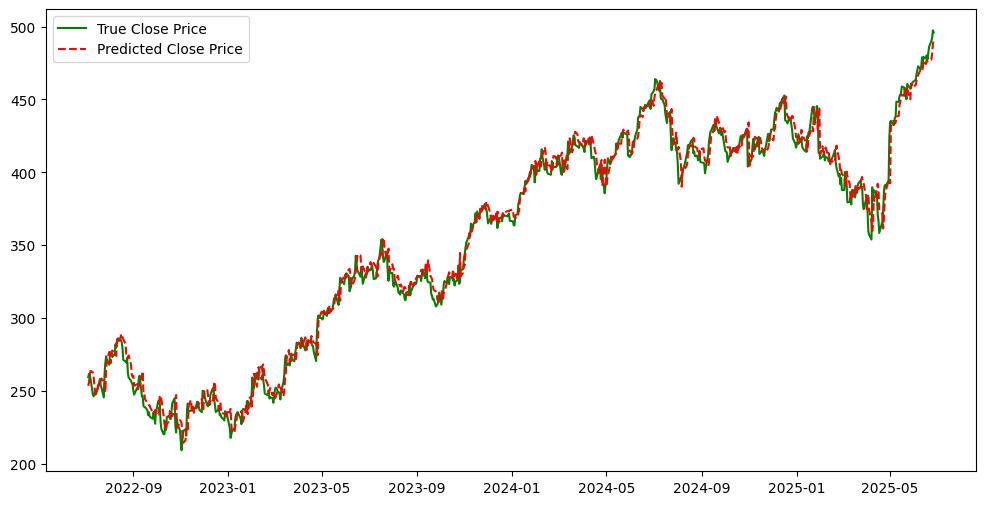

In [30]:
# Plot the model output
dates_test = stock_df.index[-len(y_test_real):]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_real, label="True Close Price", color="g")
plt.plot(dates_test, y_pred_test, label="Predicted Close Price", color="r", linestyle="--")
plt.legend()
plt.show()

The plot starts from 2024-05, not from 2020-01-01 as it only shows the model's performance on the test data, which is (2024-05 -> current)

In [31]:
# Get the MAE of the naive model to check if my model actually gives predictive value.
import numpy as np
from sklearn.metrics import mean_absolute_error

# Shift true values for comparison
naive_pred = y_test_real[:-1]
true_values = y_test_real[1:]

naive_mae = mean_absolute_error(true_values, naive_pred)
print(f"Naive model MAE: ${naive_mae:.2f}")

test_mae = mean_absolute_error(y_test_real, y_pred_test)
print(f"Test MAE: ${test_mae:.2f}")

Naive model MAE: $4.00
Test MAE: $6.06


In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader

test_preds = []
model.eval()
with torch.inference_mode():
    for xb, yb in test_loader:
        test_preds.append(model(xb).cpu().numpy())

# Stack and inverse‐scale
y_pred_test_scaled = np.vstack(test_preds)
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled)

# True test values aligned with the windows (drop the first seq_len rows)
y_true_test = y_scaler.inverse_transform(
    y_test_tensor[seq_len:].cpu().numpy()
)

test_mae = mean_absolute_error(y_true_test, y_pred_test)
print(f"Test MAE:  ${test_mae:.2f}")

# Create an evaluation loader over the training set with no shuffling
eval_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

train_preds = []
model.eval()
with torch.inference_mode():
    for xb, yb in eval_train_loader:
        train_preds.append(model(xb).cpu().numpy())

# Stack and inverse‐scale
y_pred_train_scaled = np.vstack(train_preds)
y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled)

# True train values aligned the same way
y_true_train = y_scaler.inverse_transform(
    y_train_tensor[seq_len:].cpu().numpy()
)

train_mae = mean_absolute_error(y_true_train, y_pred_train)
print(f"Train MAE: ${train_mae:.2f}")

Test MAE:  $6.06
Train MAE: $1.55


In [33]:
# 1) Build the “y_train_real” array aligned with windows, just like for test
y_true_train = y_scaler.inverse_transform(y_train_tensor[seq_len:].cpu().numpy())

# 2) Naive predicts yesterday’s price → today
naive_pred_train = y_true_train[:-1]
naive_true_train = y_true_train[1:]

naive_mae_train = mean_absolute_error(naive_true_train, naive_pred_train)
naive_mae_test  = mean_absolute_error(y_true_test[1:], y_true_test[:-1])
print("Naive Train MAE:", naive_mae_train)
print("Naive Test  MAE:", naive_mae_test)

Naive Train MAE: 1.058173656463623
Naive Test  MAE: 3.999284267425537


[I 2025-07-16 10:31:06,136] Trial 5 finished with value: 0.04554750034585595 and parameters:
- {'hidden_size': 71, 'num_layers': 1, 'dropout': 0.25336207237908526, 'lr': 0.0026520561447880915, 'batch_size': 128, 'seq_len': 28}. Best is trial 5 with value: 0.04554750034585595.

In [34]:
#!pip install optuna  # For hyperparameter tuning

In [35]:
"""import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

def objective(trial):
    # 1) Sample hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)
    lr          = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    seq_len     = trial.suggest_int("seq_len", 5, 60)

    # 2) Re-build datasets & loaders with this seq_len + batch_size
    train_ds = StockDataset(X_train_tensor, y_train_tensor, seq_len=seq_len)
    test_ds  = StockDataset(X_test_tensor,  y_test_tensor,  seq_len=seq_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # 3) Build a fresh model for this trial
    #    Replace LSTMModel with GRUModel if you prefer
    model = LSTMModel(
        input_size=X_train_tensor.shape[1],
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    )
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn   = nn.HuberLoss(delta=0.05)

    # 4) Quick train loop (you can reduce epochs for faster trials)
    epochs = 100
    for _ in range(epochs):

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss  = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    # 5) Evaluate on test set
    model.eval()
    test_losses = []
    with torch.inference_mode():
        for xb, yb in test_loader:
            preds = model(xb)
            test_losses.append(loss_fn(preds, yb).item())

    print(f"Trial {trial.number:3d} → loss: {avg_test_loss:.4f} | "
      f"hs={hidden_size}, nl={num_layers}, dr={dropout:.2f}, "
      f"lr={lr:.1e}, bs={batch_size}, seq={seq_len}")

    return sum(test_losses) / len(test_losses)

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, timeout=6000)  # e.g. 50 trials or 10 minutes
    print("Best hyperparameters:", study.best_params)
    print("Best test loss: %.4f" % study.best_value)"""

'import optuna\nfrom torch.utils.data import DataLoader\nimport torch.nn as nn\nimport torch\n\ndef objective(trial):\n    # 1) Sample hyperparameters\n    hidden_size = trial.suggest_int("hidden_size", 16, 128)\n    num_layers  = trial.suggest_int("num_layers", 1, 3)\n    dropout     = trial.suggest_float("dropout", 0.0, 0.5)\n    lr          = trial.suggest_float("lr", 1e-5, 1e-2, log=True)\n    batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64, 128])\n    seq_len     = trial.suggest_int("seq_len", 5, 60)\n\n    # 2) Re-build datasets & loaders with this seq_len + batch_size\n    train_ds = StockDataset(X_train_tensor, y_train_tensor, seq_len=seq_len)\n    test_ds  = StockDataset(X_test_tensor,  y_test_tensor,  seq_len=seq_len)\n    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)\n    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)\n\n    # 3) Build a fresh model for this trial\n    #    Replace LSTMModel with GRUMode